In [1]:
%load_ext autoreload
%autoreload 2

from mnist.model import Model
from mnist.dataset import MNIST
import plotly.express as px
from einops import *
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

color = dict(color_continuous_scale="RdBu", range_color = [-0.25, 0.25])

# Model Training

In [169]:
# Single-layer MNIST training
torch.set_grad_enabled(True)

# The input norm is about 0.3, so we scale the input noise to 1.0, same as the previous implementation
model = Model.from_config(epochs=30, wd=0., noise=1.0, n_layer=1, residual=True, device='mps', seed = 42).to('mps')

train, test = MNIST(train=True, download=True, device='mps'), MNIST(train=False, download=True, device='mps')
metrics = model.fit(train, test)
# px.line(metrics, x=metrics.index, y=["train/acc", "val/acc"], title="Acc")

torch.set_grad_enabled(False)
model.to('cpu')

  0%|          | 0/30 [00:00<?, ?it/s]

train/loss: 0.061, train/acc: 0.981, val/loss: 0.060, val/acc: 0.983: 100%|██████████| 30/30 [01:18<00:00,  2.60s/it]


Model(
  (embed): Linear(
    in_features=784, out_features=512, bias=False
    (noise): Noise()
    (gate): Identity()
  )
  (blocks): ModuleList(
    (0): Bilinear(
      in_features=512, out_features=1024, bias=False
      (noise): Identity()
      (gate): Identity()
    )
  )
  (head): Linear(
    in_features=512, out_features=10, bias=False
    (noise): Identity()
    (gate): Identity()
  )
  (criterion): CrossEntropyLoss()
)

In [2]:
data = {'config':model.config, 'model':model.state_dict()}
torch.save(data, 'data/adversarial_model_noise05_seed42')

NameError: name 'model' is not defined

In [6]:
data['config']

Config {
  "batch_size": 2048,
  "bias": false,
  "d_hidden": 512,
  "d_input": 784,
  "d_output": 10,
  "device": "mps",
  "epochs": 30,
  "lr": 0.001,
  "n_layer": 1,
  "noise": 0.5,
  "residual": true,
  "seed": 42,
  "transformers_version": "4.37.2",
  "wd": 0.0
}

In [3]:
train, test = MNIST(train=True, download=True, device='mps'), MNIST(train=False, download=True, device='mps')
data = torch.load('data/adversarial_model_noise05_seed42.pt')
model = Model(data['config'])
model.load_state_dict(data['model'])
torch.set_grad_enabled(False)
model.to('cpu')

Model(
  (embed): Linear(
    in_features=784, out_features=512, bias=False
    (noise): Noise()
    (gate): Identity()
  )
  (blocks): ModuleList(
    (0): Bilinear(
      in_features=512, out_features=1024, bias=False
      (noise): Identity()
      (gate): Identity()
    )
  )
  (head): Linear(
    in_features=512, out_features=10, bias=False
    (noise): Identity()
    (gate): Identity()
  )
  (criterion): CrossEntropyLoss()
)

In [179]:
import gc

gc.collect()
gc.collect()
torch.mps.empty_cache()

## Dense Adversarial Masks

## Find encoders for eigenvectors
We approximate the encoder as the pseudoinverse of the set of top positive eigenvectors

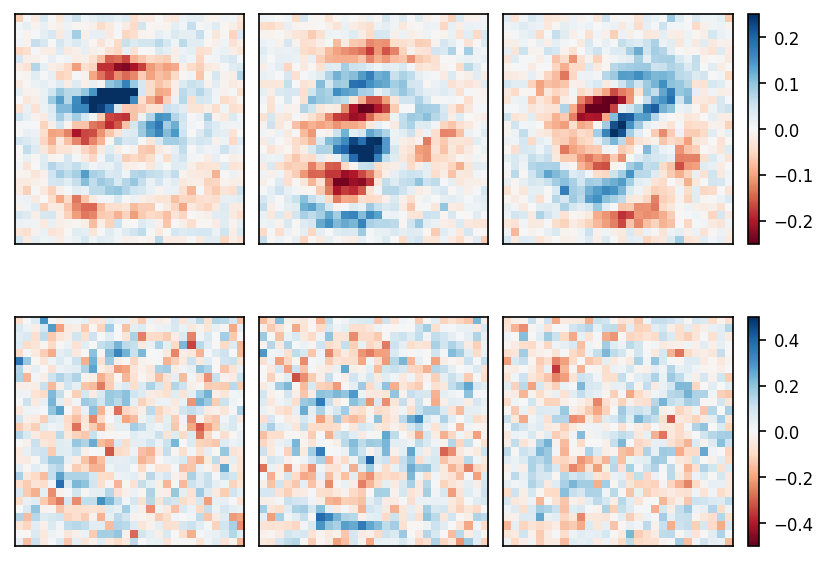

In [4]:
# Pseudo-inverse eigenvectors

digit = 3
nondigits = [i for i in range(10) if i != digit]

l, r = model.w_b[0].unbind()

b = einsum(model.w_u, l, r, "cls out, out in1, out in2 -> cls in1 in2")
b = 0.5 * (b + b.mT) #B tensor

eigvals, eigvecs = torch.linalg.eigh(b)
eigvecs = rearrange(eigvecs, "cls model eig -> cls eig model")

topk_per_sign = 10
decoders = eigvecs[:, -topk_per_sign:]

encoders = torch.linalg.pinv(rearrange(decoders, "cls eig model -> (cls eig) model"))
encoders = rearrange(encoders, "model (cls eig) -> cls eig model", cls=10)

encoders_input = einsum(encoders, model.w_e, "cls eig model, model pix -> cls eig pix")
decoders_input = einsum(decoders, model.w_e, "cls eig model, model pix -> cls eig pix")

#set signs
data = torch.stack([test.x[test.y==i][:500] for i in range(10)], dim=0)
data = data.cpu()
overlaps = einsum(decoders_input, data, "digit1 eig pix, digit2 sample pix -> digit1 eig sample digit2")
mask = ( 1 - torch.eye(10))
overlaps = overlaps * mask[:,None, None, :]
signs = overlaps.sum(dim=-1).sum(dim=-1).sign()

encoders_input *= signs[:,:, None]
decoders_input *= signs[:,:, None]

fig = plt.figure(dpi=150)

idxs = torch.arange(-3, 0).flip(0)
num = len(idxs)

grid = ImageGrid(fig, 211, nrows_ncols=(1,num), axes_pad = 0.1, cbar_location='right', cbar_mode='single')
for i in range(num):
    im = grid[i].imshow(decoders_input[digit, idxs[i]].view(28, 28), cmap='RdBu', vmin=-0.25, vmax=0.25)
    grid[i].set_xticks([])
    grid[i].set_yticks([])
grid.cbar_axes[0].colorbar(im)
grid.cbar_axes[0].tick_params(labelsize=8)

grid = ImageGrid(fig, 212, nrows_ncols=(1,num), axes_pad = 0.1, cbar_location='right', cbar_mode='single')
for i in range(num):
    im = grid[i].imshow(encoders_input[digit, idxs[i]].view(28, 28), cmap='RdBu', vmin=-0.5, vmax=0.5)
    grid[i].set_xticks([])
    grid[i].set_yticks([])
grid.cbar_axes[0].colorbar(im)
grid.cbar_axes[0].tick_params(labelsize=8)

## Example for single input

Text(0, 0.5, 'Logit')

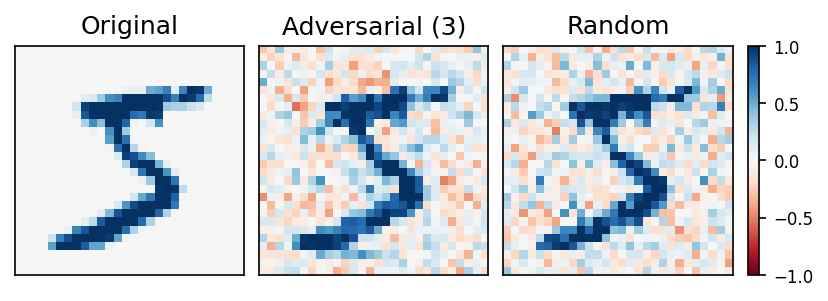

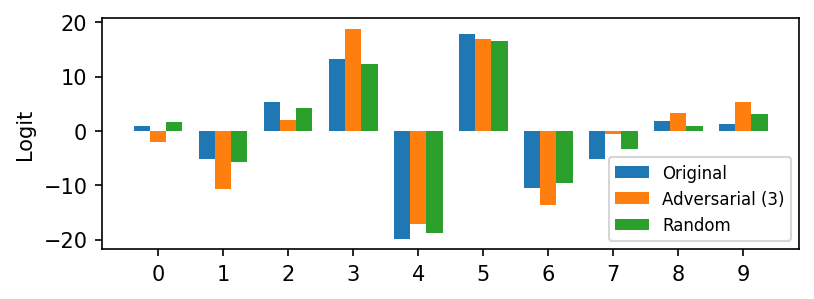

In [7]:
digit = 3
eig_idx = -2
strength = 0.2

mask = encoders_input[digit, eig_idx]
mask /= mask.std(dim=-1, keepdim=True)
mask = strength * mask

idx = 0
input = train.x[idx].cpu()

in_adv = input + mask
in_rand = input + mask[torch.randperm(len(mask))]
inputs = [input, in_adv, in_rand]
labels = ['Original', f'Adversarial ({digit})', 'Random']

fig=plt.figure(dpi=150)
grid = ImageGrid(fig, 111, nrows_ncols=(1,3), axes_pad = 0.1, cbar_location='right', cbar_mode='single')
for i, x in enumerate(inputs):
    im = grid[i].imshow(x.view(28, 28), cmap='RdBu', vmin=-1, vmax=1)
    grid[i].set_title(labels[i])
    grid[i].set_xticks([])
    grid[i].set_yticks([])
grid.cbar_axes[0].colorbar(im)
grid.cbar_axes[0].tick_params(labelsize=8)

logits = []
for x in inputs:
    logits.append(model.eval().forward(x.flatten()))

fig=plt.figure(figsize=(6,2), dpi=150)
width = 0.25
for i in range(len(inputs)):
    x = np.arange(len(logits[0])) + (i-1)*width
    plt.bar(x, logits[i], width=width, label=labels[i])
plt.legend(prop={'size':8})
plt.xticks(range(10))
# plt.xlabel('Digit')
plt.ylabel('Logit')

# Evaluate over adversarial masks

In [184]:
def evaluate_mask(mask, digit):
    inputs = train.x.cpu()
    logits_list = [
        model.eval().forward(inputs), #original
        model.eval().forward(inputs + mask.unsqueeze(0)), #adversarial
        model.eval().forward(inputs + mask[torch.randperm(len(mask))].unsqueeze(0)), #random
    ]
    labels = ['orig', 'adv', 'rand']

    metrics = {}
    for logits, label in zip(logits_list, labels):
        metrics[f'avg_logits_{label}'] = logits.mean(dim=0)
        metrics[f'accuracy_{label}'] = (logits.argmax(dim=-1) == train.y.cpu()).float().mean()
        metrics[f'misclassify_rate_{label}'] = ((logits.argmax(dim=-1) == digit) & (train.y.cpu() != digit)).float().mean()
    return metrics

In [185]:
from collections import defaultdict

strengths = np.arange(0.025,.301,0.025)
digits = range(10)
eig_idxs = [-1, -2, -3]

def func():
    return torch.zeros(len(digits), len(eig_idxs), len(strengths))
eval_metrics = defaultdict(func)
for digit in range(10):
    for e, eig_idx in enumerate(eig_idxs):
        for s, strength in enumerate(strengths):
            strength = np.round(strength, 3)
            mask = encoders_input[digit, eig_idx]
            mask /= mask.std(dim=-1, keepdim=True)
            mask = strength * mask
            metrics = evaluate_mask(mask, digit)
            print((digit, eig_idx, strength, metrics['accuracy_adv'], metrics['misclassify_rate_adv']))

            for key in metrics.keys():
                if key.startswith('avg_logits'):
                    continue
                eval_metrics[key][digit, e, s]  = metrics[key]

(0, -1, 0.025, tensor(0.9952), tensor(0.0003))
(0, -1, 0.05, tensor(0.9942), tensor(0.0004))
(0, -1, 0.075, tensor(0.9923), tensor(0.0007))
(0, -1, 0.1, tensor(0.9891), tensor(0.0016))
(0, -1, 0.125, tensor(0.9843), tensor(0.0026))
(0, -1, 0.15, tensor(0.9783), tensor(0.0043))
(0, -1, 0.175, tensor(0.9702), tensor(0.0066))
(0, -1, 0.2, tensor(0.9593), tensor(0.0100))
(0, -1, 0.225, tensor(0.9442), tensor(0.0150))
(0, -1, 0.25, tensor(0.9233), tensor(0.0228))
(0, -1, 0.275, tensor(0.8937), tensor(0.0336))
(0, -1, 0.3, tensor(0.8554), tensor(0.0486))
(0, -2, 0.025, tensor(0.9953), tensor(0.0004))
(0, -2, 0.05, tensor(0.9943), tensor(0.0006))
(0, -2, 0.075, tensor(0.9923), tensor(0.0014))
(0, -2, 0.1, tensor(0.9900), tensor(0.0025))
(0, -2, 0.125, tensor(0.9866), tensor(0.0037))
(0, -2, 0.15, tensor(0.9815), tensor(0.0065))
(0, -2, 0.175, tensor(0.9754), tensor(0.0107))
(0, -2, 0.2, tensor(0.9661), tensor(0.0173))
(0, -2, 0.225, tensor(0.9538), tensor(0.0270))
(0, -2, 0.25, tensor(0.9372)

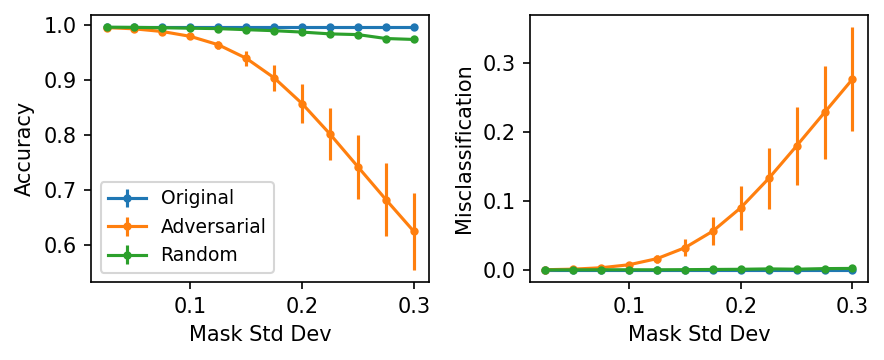

In [186]:
plt.figure(figsize=(6, 2.5), dpi=150)

plt.subplot(1,2,1)
keys = ['accuracy_orig', 'accuracy_adv', 'accuracy_rand']
labels = ['Original', 'Adversarial', 'Random']
for key, label in zip(keys, labels):
    values =  eval_metrics[key].view(-1,len(strengths))
    means = values.mean(0)
    stds = values.std(0) / np.sqrt(values.shape[0])
    plt.errorbar(strengths, means, yerr=1.96*stds, fmt='o-', markersize=3, label=label)
plt.xlabel('Mask Std Dev')
plt.ylabel('Accuracy')
# plt.title('Accuracy')
plt.legend(prop={'size':9})

plt.subplot(1,2,2)
keys = ['misclassify_rate_orig', 'misclassify_rate_adv', 'misclassify_rate_rand']
for key, label in zip(keys, labels):
    values =  eval_metrics[key].view(-1,len(strengths))
    means = values.mean(0)
    stds = values.std(0) / np.sqrt(values.shape[0])
    plt.errorbar(strengths, means, yerr=1.96*stds, fmt='o-', markersize=3, label=label)
plt.xlabel('Mask Std Dev')
plt.ylabel('Misclassification')
# plt.title('Misclassification as Adversary')

plt.tight_layout()
plt.show()